# Dataset and preprocessing:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#import sklearn as skl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)

tf.compat.v1.set_random_seed(2)

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#import sklearn as skl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)

tf.compat.v1.set_random_seed(1)

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]


import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse

torch.manual_seed(13)

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

matplotlib.style.use('ggplot')

import easydict
import torch.nn as nn


In [3]:

df = pd.read_csv("processminer-rare-event-mts - data.csv") 
df.head(n=5)  

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,-0.038189,0.877951,-0.052959,-13.306135,0.101068,0.041800,0.199901,-2.327329,-0.944167,3.075199,0.123154,-0.104334,-0.570710,-9.784456,0.355960,15.842819,-0.451973,-0.105282,96,-134.27786,0.058726,-0.021645,9.366755,0.002151,-69.187583,4.232571,-0.225267,-0.196872,-0.072449,-0.103732,-0.720746,-5.412436,76.679042,-0.632727,1351.63286,-0.657095,-0.434947,-108.77597,0.084856,10.210182,11.295155,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,-0.038189,0.873273,-0.014244,-13.306135,0.101108,0.041447,0.304313,-2.340627,-0.939994,3.075199,0.123154,-0.104334,-0.574861,-9.784456,0.360160,16.491684,-0.450451,-0.092430,96,-134.48019,0.058759,-0.004579,9.350215,0.002149,-68.585197,4.311490,-0.225267,-0.196872,-0.059103,-0.083895,-0.720746,-8.343222,78.181598,-0.632727,1370.37895,-0.875629,-1.125819,-108.84897,0.085146,12.534340,11.290761,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,-0.018352,1.004910,0.065150,-9.619596,0.101148,0.041095,0.252839,-2.353925,-0.935824,3.075199,0.123154,-0.104334,-0.579013,-9.784456,0.364356,15.972885,-0.448927,-0.097144,96,-133.94659,0.058791,-0.084658,9.037409,0.002148,-67.838187,4.809914,-0.225267,-0.186801,-0.048696,-0.073823,-0.720746,-1.085166,79.684154,-0.632727,1368.12309,-0.037775,-0.519541,-109.08658,0.085436,18.582893,11.286366,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,-0.008280,0.930037,-0.067199,-15.196531,0.101188,0.040742,0.072873,-2.367223,-0.931651,3.075199,0.123154,-0.104334,-0.583165,-9.784456,0.368556,15.608688,-0.447404,-0.160073,96,-134.00259,0.058824,-0.055118,9.020625,0.002146,-67.091148,5.308343,-0.225267,-0.186801,-0.047017,-0.063752,-0.720746,6.172891,81.186702,-0.632727,1365.69145,-0.987410,0.674524,-109.56277,0.085726,17.719032,11.281972,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,-0.008280,0.828410,-0.018472,-14.609266,0.101229,0.040390,0.171033,-2.380521,-0.927478,3.075199,0.123154,-0.104334,-0.587316,-9.784456,0.372756,15.606125,-0.445879,-0.131630,96,-133.14571,0.058856,-0.153851,9.344233,0.002145,-65.991813,5.806771,-0.225267,-0.186801,-0.057088,-0.063752,-0.720746,-3.379599,82.689258,-0.632727,1363.25786,-0.238445,-0.063044,-110.03891,0.086016,16.855202,11.277577,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [4]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [5]:
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,time,y,x1,x2,x3
256,5/1/99 8:32,0,1.016235,-4.058394,-1.097158
257,5/1/99 8:34,0,1.005602,-3.876199,-1.074373
258,5/1/99 8:36,0,0.933933,-3.868467,-1.249954
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578
260,5/1/99 10:50,0,0.020062,-3.987897,-1.248529


After shifting


,y,time,x1,x2,x3
255,0.0,5/1/99 8:30,0.997107,-3.865720,-1.133779
256,0.0,5/1/99 8:32,1.016235,-4.058394,-1.097158
257,1.0,5/1/99 8:34,1.005602,-3.876199,-1.074373
258,1.0,5/1/99 8:36,0.933933,-3.868467,-1.249954
260,0.0,5/1/99 10:50,0.020062,-3.987897,-1.248529


In [6]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

In [7]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [8]:
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_0_y = np.array(df_train_0['y'])
df_train_1_x = df_train_1.drop(['y'], axis=1)
df_train_1_y = np.array(df_train_1['y'])

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_0_y = np.array(df_valid_0['y'])
df_valid_1_x = df_valid_1.drop(['y'], axis=1)
df_valid_1_y = np.array(df_valid_1['y'])

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_0_y = np.array(df_valid_0['y'])
df_test_1_x = df_test_1.drop(['y'], axis=1)
df_test_0_y = np.array(df_valid_0['y'])

In [9]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)

df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

In [10]:
print(df_train_0_x_rescaled.shape)
print(df_valid_0_x_rescaled.shape)
print(df_test_0_x_rescaled.shape)
print(df_test_x_rescaled.shape)

(11541, 59)
(2883, 59)
(3603, 59)
(3655, 59)


In [11]:
from torch.utils.data import Dataset

In [12]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index): ## generator 
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.data[index].astype(np.uint8)
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

data = df_train_0_x_rescaled
targets = df_train_0_y

#transform = transforms.Compose([transforms.ToTensor()])
train_data = MyDataset(data, targets)#, transform=transform)


In [13]:
data2 = df_valid_0_x_rescaled
targets2 = df_test_0_y

#transform = transforms.Compose([transforms.ToTensor()])
test_data = MyDataset(data2, targets2)#, transform=transform)


# Model:

## Code:

In [14]:

args = easydict.EasyDict({
    'epochs':50
})

epochs = args['epochs']
learning_rate = 1e-3
batch_size = 150

In [15]:

# trainloader
trainloader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True
)
#testloader
testloader = DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False
)

In [16]:
# get the computation device
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()


In [17]:
# define the autoencoder model
class Autoencoder(nn.Module):
   # In the __init__ function, you are supposed to initialize the layers you want to use. 
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # encoder
        self.enc1 = nn.Linear(in_features=59, out_features=45, bias= True) 
        self.enc2 = nn.Linear(in_features=45, out_features=32, bias= True) 
        self.enc3 = nn.Linear(in_features=32, out_features=16, bias= True) 
        
        self.cod1 = nn.Linear(in_features=16, out_features=16, bias= True) 
        
        # decoder
        self.dec4 = nn.Linear(in_features=16, out_features=32, bias= True) 
        self.dec5 = nn.Linear(in_features=32, out_features=45, bias= True) 
        self.dec6 = nn.Linear(in_features=45, out_features=59, bias= True)

    def forward(self, x):
        # encoding
        x = torch.relu(self.enc1(x))
        x = torch.relu(self.enc2(x))
        x = torch.relu(self.enc3(x))
        x = torch.relu(self.cod1(x))
        # decoding
        x = torch.relu(self.dec4(x))
        x = torch.relu(self.dec5(x))
        x = self.dec6(x)
        return x

model1 = Autoencoder().to(device)



In [18]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model1.parameters(), lr=learning_rate) #Adam

In [19]:
# get the layers as a list
model_children = list(model1.children())
model1 = model1.double()

In [20]:
# define the training function
def fit(model, dataloader, epoch):
    train_loss = []
    print('Training')
    model.train()
    running_loss = 0.0

    counter = 0
    correct = 0
    total = 0 
    for i, data in tqdm(enumerate(dataloader), total=int(len(df_train_0_x_rescaled)/dataloader.batch_size)):
        counter += 1
        img = data[0]
        target = data[1] 
        tamanho = int(np.array(data[1].shape))
        img = img.to(device)
        target = target.to(device)

        img = img.view(img.size(0), -1)
        
        optimizer.zero_grad()
        outputs = model(img.double()) ##  
        loss_super = criterion(outputs, img) # supervised loss
       
        ## Loss
        loss = loss_super
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / counter 
    print(f"Train Loss: {epoch_loss:.3f}")

    return epoch_loss, outputs#, jacob

In [21]:
# define the validation function
def validate(model, dataloader, epoch):
    print('Validating')
    model.eval()
    running_loss = 0.0

    counter = 0
    correct = 0
    total = 0 
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(df_valid_0_x_rescaled)/dataloader.batch_size)):
            counter += 1
            img = data[0]
            target = data[1] 
           
            img = img.to(device)
            target = target.to(device)

            img = img.view(img.size(0), -1)
            outputs = model(img.double())
            loss = criterion(outputs, img)
            running_loss += loss.item()
            


    epoch_loss = running_loss / counter 

    print(f"Val Loss: {epoch_loss:.3f}")  
    return epoch_loss, outputs

## Trein:

In [22]:
# train and validate the autoencoder neural network
train_loss1 = []
val_loss1 = []
start1 = time.time()
for epoch in range(epochs):
    #print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss1, outputs1 = fit(model1, trainloader, epoch)
    val_epoch_loss1, preds1 = validate(model1, testloader, epoch)
   
    train_loss1.append(train_epoch_loss1)
    val_loss1.append(val_epoch_loss1)
    
end1 = time.time()
 
print(f"{(end1-start1)/60:.3} minutes")

 38%|███▊      | 29/76 [00:00<00:00, 275.64it/s]

Training


77it [00:00, 252.05it/s]                        
20it [00:00, 428.90it/s]              
 32%|███▏      | 24/76 [00:00<00:00, 230.81it/s]

Train Loss: 0.942
Validating
Val Loss: 0.731
Training


77it [00:00, 243.93it/s]                        
20it [00:00, 599.68it/s]              
 30%|███       | 23/76 [00:00<00:00, 229.18it/s]

Train Loss: 0.642
Validating
Val Loss: 0.586
Training


77it [00:00, 215.14it/s]                        
20it [00:00, 544.91it/s]              
 30%|███       | 23/76 [00:00<00:00, 229.56it/s]

Train Loss: 0.494
Validating
Val Loss: 0.442
Training


77it [00:00, 230.29it/s]                        
20it [00:00, 463.93it/s]              
 38%|███▊      | 29/76 [00:00<00:00, 284.38it/s]

Train Loss: 0.409
Validating
Val Loss: 0.388
Training


77it [00:00, 257.40it/s]                        
20it [00:00, 551.16it/s]              
 32%|███▏      | 24/76 [00:00<00:00, 239.68it/s]

Train Loss: 0.367
Validating
Val Loss: 0.352
Training


77it [00:00, 256.34it/s]                        
20it [00:00, 417.45it/s]              
 38%|███▊      | 29/76 [00:00<00:00, 282.76it/s]

Train Loss: 0.339
Validating
Val Loss: 0.330
Training


77it [00:00, 264.66it/s]                        
20it [00:00, 456.57it/s]              
 37%|███▋      | 28/76 [00:00<00:00, 277.08it/s]

Train Loss: 0.318
Validating
Val Loss: 0.310
Training


77it [00:00, 269.37it/s]                        
20it [00:00, 556.20it/s]              
 39%|███▉      | 30/76 [00:00<00:00, 296.93it/s]

Train Loss: 0.301
Validating
Val Loss: 0.294
Training


77it [00:00, 255.01it/s]                        
20it [00:00, 526.09it/s]              
 37%|███▋      | 28/76 [00:00<00:00, 274.17it/s]

Train Loss: 0.288
Validating
Val Loss: 0.284
Training


77it [00:00, 258.74it/s]                        
20it [00:00, 585.97it/s]              
 38%|███▊      | 29/76 [00:00<00:00, 282.85it/s]

Train Loss: 0.277
Validating
Val Loss: 0.274
Training


77it [00:00, 267.53it/s]                        
20it [00:00, 526.00it/s]              
 36%|███▌      | 27/76 [00:00<00:00, 269.13it/s]

Train Loss: 0.268
Validating
Val Loss: 0.263
Training


77it [00:00, 266.08it/s]                        
20it [00:00, 584.10it/s]              
 36%|███▌      | 27/76 [00:00<00:00, 268.44it/s]

Train Loss: 0.258
Validating
Val Loss: 0.253
Training


77it [00:00, 262.34it/s]                        
20it [00:00, 570.15it/s]              
 36%|███▌      | 27/76 [00:00<00:00, 269.95it/s]

Train Loss: 0.247
Validating
Val Loss: 0.245
Training


77it [00:00, 273.37it/s]                        
20it [00:00, 448.33it/s]              
 33%|███▎      | 25/76 [00:00<00:00, 243.90it/s]

Train Loss: 0.239
Validating
Val Loss: 0.238
Training


77it [00:00, 257.69it/s]                        
20it [00:00, 522.96it/s]              
 37%|███▋      | 28/76 [00:00<00:00, 265.03it/s]

Train Loss: 0.232
Validating
Val Loss: 0.231
Training


77it [00:00, 245.14it/s]
20it [00:00, 634.05it/s]              
 37%|███▋      | 28/76 [00:00<00:00, 276.53it/s]

Train Loss: 0.226
Validating
Val Loss: 0.226
Training


77it [00:00, 266.87it/s]                        
20it [00:00, 602.06it/s]              
 38%|███▊      | 29/76 [00:00<00:00, 286.16it/s]

Train Loss: 0.221
Validating
Val Loss: 0.222
Training


77it [00:00, 255.59it/s]                        
20it [00:00, 604.90it/s]              
 33%|███▎      | 25/76 [00:00<00:00, 249.03it/s]

Train Loss: 0.217
Validating
Val Loss: 0.219
Training


77it [00:00, 257.15it/s]                        
20it [00:00, 613.97it/s]              
 36%|███▌      | 27/76 [00:00<00:00, 268.00it/s]

Train Loss: 0.213
Validating
Val Loss: 0.214
Training


77it [00:00, 269.60it/s]                        
20it [00:00, 600.97it/s]              
 34%|███▍      | 26/76 [00:00<00:00, 251.78it/s]

Train Loss: 0.210
Validating
Val Loss: 0.211
Training


77it [00:00, 245.37it/s]
20it [00:00, 561.23it/s]              
 36%|███▌      | 27/76 [00:00<00:00, 262.71it/s]

Train Loss: 0.206
Validating
Val Loss: 0.207
Training


77it [00:00, 263.44it/s]                        
20it [00:00, 486.23it/s]              
 34%|███▍      | 26/76 [00:00<00:00, 252.26it/s]

Train Loss: 0.202
Validating
Val Loss: 0.204
Training


77it [00:00, 259.17it/s]                        
20it [00:00, 600.01it/s]              
 36%|███▌      | 27/76 [00:00<00:00, 268.63it/s]

Train Loss: 0.199
Validating
Val Loss: 0.200
Training


77it [00:00, 260.20it/s]                        
20it [00:00, 534.35it/s]              
 30%|███       | 23/76 [00:00<00:00, 227.40it/s]

Train Loss: 0.195
Validating
Val Loss: 0.199
Training


77it [00:00, 255.93it/s]                        
20it [00:00, 599.77it/s]              
 37%|███▋      | 28/76 [00:00<00:00, 275.40it/s]

Train Loss: 0.193
Validating
Val Loss: 0.194
Training


77it [00:00, 269.63it/s]                        
20it [00:00, 594.68it/s]              
 36%|███▌      | 27/76 [00:00<00:00, 263.36it/s]

Train Loss: 0.190
Validating
Val Loss: 0.192
Training


77it [00:00, 262.25it/s]                        
20it [00:00, 512.65it/s]              
 36%|███▌      | 27/76 [00:00<00:00, 264.38it/s]

Train Loss: 0.187
Validating
Val Loss: 0.190
Training


77it [00:00, 246.33it/s]
20it [00:00, 553.38it/s]              
 37%|███▋      | 28/76 [00:00<00:00, 274.48it/s]

Train Loss: 0.184
Validating
Val Loss: 0.188
Training


77it [00:00, 269.41it/s]                        
20it [00:00, 572.57it/s]              
 39%|███▉      | 30/76 [00:00<00:00, 297.19it/s]

Train Loss: 0.182
Validating
Val Loss: 0.186
Training


77it [00:00, 278.87it/s]                        
20it [00:00, 491.96it/s]              
 34%|███▍      | 26/76 [00:00<00:00, 259.88it/s]

Train Loss: 0.180
Validating
Val Loss: 0.184
Training


77it [00:00, 261.91it/s]                        
20it [00:00, 601.33it/s]              
 34%|███▍      | 26/76 [00:00<00:00, 253.48it/s]

Train Loss: 0.178
Validating
Val Loss: 0.182
Training


77it [00:00, 264.09it/s]                        
20it [00:00, 557.25it/s]              
 38%|███▊      | 29/76 [00:00<00:00, 286.01it/s]

Train Loss: 0.177
Validating
Val Loss: 0.179
Training


77it [00:00, 259.29it/s]                        
20it [00:00, 462.02it/s]              
 34%|███▍      | 26/76 [00:00<00:00, 255.25it/s]

Train Loss: 0.175
Validating
Val Loss: 0.179
Training


77it [00:00, 261.07it/s]                        
20it [00:00, 509.60it/s]              
 39%|███▉      | 30/76 [00:00<00:00, 291.60it/s]

Train Loss: 0.173
Validating
Val Loss: 0.177
Training


77it [00:00, 267.34it/s]                        
20it [00:00, 635.60it/s]              
 37%|███▋      | 28/76 [00:00<00:00, 277.52it/s]

Train Loss: 0.172
Validating
Val Loss: 0.175
Training


77it [00:00, 250.22it/s]
20it [00:00, 551.65it/s]              
 37%|███▋      | 28/76 [00:00<00:00, 273.36it/s]

Train Loss: 0.170
Validating
Val Loss: 0.176
Training


77it [00:00, 243.48it/s]                        
20it [00:00, 520.99it/s]              
 38%|███▊      | 29/76 [00:00<00:00, 287.71it/s]

Train Loss: 0.169
Validating
Val Loss: 0.173
Training


77it [00:00, 262.72it/s]                        
20it [00:00, 588.46it/s]              
 38%|███▊      | 29/76 [00:00<00:00, 284.25it/s]

Train Loss: 0.167
Validating
Val Loss: 0.171
Training


77it [00:00, 265.10it/s]                        
20it [00:00, 323.99it/s]              
 32%|███▏      | 24/76 [00:00<00:00, 238.31it/s]

Train Loss: 0.166
Validating
Val Loss: 0.170
Training


77it [00:00, 245.58it/s]                        
20it [00:00, 528.76it/s]              
 33%|███▎      | 25/76 [00:00<00:00, 246.73it/s]

Train Loss: 0.165
Validating
Val Loss: 0.169
Training


77it [00:00, 253.58it/s]                        
20it [00:00, 555.64it/s]              
 37%|███▋      | 28/76 [00:00<00:00, 277.29it/s]

Train Loss: 0.164
Validating
Val Loss: 0.169
Training


77it [00:00, 249.73it/s]
20it [00:00, 525.26it/s]              
 38%|███▊      | 29/76 [00:00<00:00, 282.63it/s]

Train Loss: 0.163
Validating
Val Loss: 0.168
Training


77it [00:00, 260.87it/s]                        
20it [00:00, 558.42it/s]              
 33%|███▎      | 25/76 [00:00<00:00, 248.39it/s]

Train Loss: 0.161
Validating
Val Loss: 0.167
Training


77it [00:00, 262.72it/s]                        
20it [00:00, 462.50it/s]              
 33%|███▎      | 25/76 [00:00<00:00, 246.34it/s]

Train Loss: 0.161
Validating
Val Loss: 0.166
Training


77it [00:00, 241.70it/s]                        
20it [00:00, 586.95it/s]              
 36%|███▌      | 27/76 [00:00<00:00, 266.93it/s]

Train Loss: 0.159
Validating
Val Loss: 0.165
Training


77it [00:00, 234.56it/s]                        
20it [00:00, 527.95it/s]              
 37%|███▋      | 28/76 [00:00<00:00, 278.61it/s]

Train Loss: 0.158
Validating
Val Loss: 0.163
Training


77it [00:00, 256.64it/s]                        
20it [00:00, 426.58it/s]              
 34%|███▍      | 26/76 [00:00<00:00, 257.07it/s]

Train Loss: 0.157
Validating
Val Loss: 0.164
Training


77it [00:00, 246.98it/s]                        
20it [00:00, 450.67it/s]              
 36%|███▌      | 27/76 [00:00<00:00, 266.57it/s]

Train Loss: 0.157
Validating
Val Loss: 0.162
Training


77it [00:00, 243.65it/s]                        
20it [00:00, 533.78it/s]              
 37%|███▋      | 28/76 [00:00<00:00, 276.50it/s]

Train Loss: 0.155
Validating
Val Loss: 0.161
Training


77it [00:00, 240.79it/s]                        
20it [00:00, 553.41it/s]              

Train Loss: 0.154
Validating
Val Loss: 0.161
0.298 minutes


# Results:

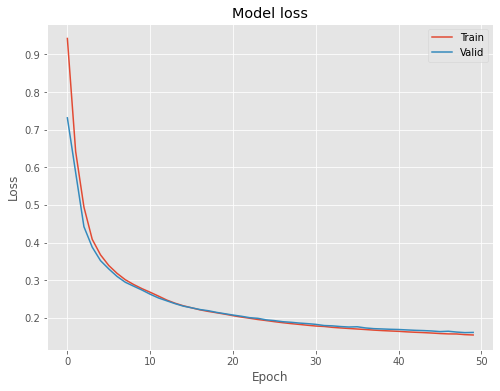

In [23]:
plt.plot(train_loss1, label='Train')
plt.plot(val_loss1, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Precision and Recall:

In [24]:
# then put it on the GPU, make it float and insert a fake batch dimension
valid_value1 = torch.tensor(df_valid_x_rescaled).to(device)
valid_value1 = valid_value1.double()
valid_value1 = valid_value1.unsqueeze(0)

# pass it through the model
prediction_valid1 = model1(valid_value1)

# get the result out and reshape it
cpu_pred_valid1 = prediction_valid1.cpu()
valid_x_predictions_valid1 = cpu_pred_valid1.data.numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


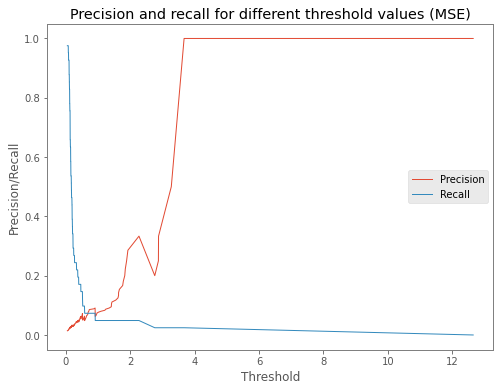

In [25]:
#valid_x_predictions_valid = model3(df_valid_x_rescaled)
mse1 = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions_valid1[0], 2), axis=1)
error_df1 = pd.DataFrame({'Reconstruction_error': mse1,
                        'True_class': df_valid['y']})

precision_rt1, recall_rt1, threshold_rt1 = precision_recall_curve(error_df1.True_class, error_df1.Reconstruction_error)
#plt.xlim([-0.01, 1])
plt.plot(threshold_rt1, precision_rt1[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt1, recall_rt1[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values (MSE)')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
ax = plt.axes()
# Setting the background color
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.set_facecolor("white")
plt.show()

### Class Division:

In [26]:
# then put it on the GPU, make it float and insert a fake batch dimension
test_value1 = torch.tensor(df_test_x_rescaled).to(device)
test_value1 = test_value1.double()
#test_value = test_value.unsqueeze(0)

# pass it through the model
prediction1 = model1(test_value1)

# get the result out and reshape it
cpu_pred1 = prediction1.cpu()
test_x_predictions1 = cpu_pred1.data.numpy()

In [27]:
#test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse1 = np.mean(np.power(df_test_x_rescaled - test_x_predictions1, 2), axis=1)
error_df_test1 = pd.DataFrame({'Reconstruction_error': mse1,
                        'True_class': df_test['y']})
error_df_test1 = error_df_test1.reset_index()

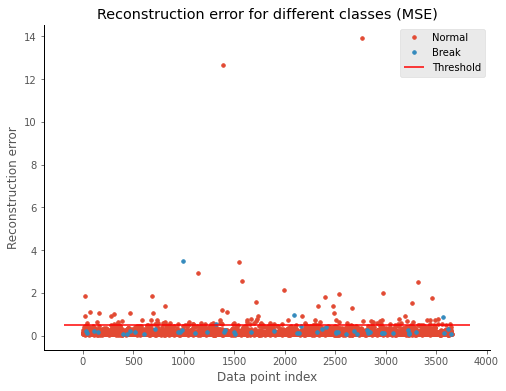

In [28]:
threshold_fixed1 = 0.5
groups = error_df_test1.groupby('True_class')

fig, ax = plt.subplots()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor("white")
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed1, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes (MSE)")
plt.ylabel("Reconstruction error")

plt.xlabel("Data point index")

plt.show()

### Confusion Matrix:

In [29]:
pred_y1 = [1 if e > threshold_fixed1 else 0 for e in error_df1.Reconstruction_error.values]

In [30]:
predictions1 = pd.DataFrame({'true': error_df1.True_class,
                           'predicted': pred_y1})

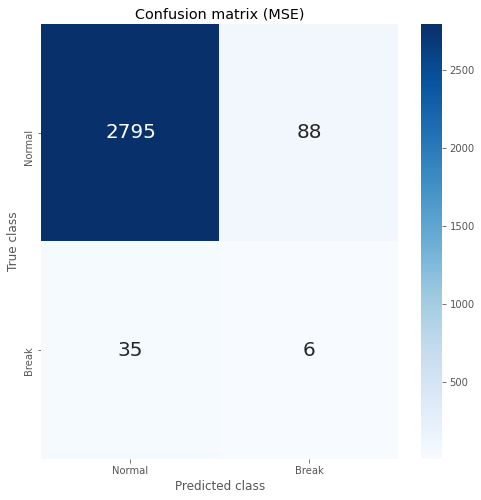

In [31]:
conf_matrix = confusion_matrix(error_df1.True_class, pred_y1)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d', cmap='Blues', annot_kws={"size":20});
plt.title("Confusion matrix (MSE)")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### ROC:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


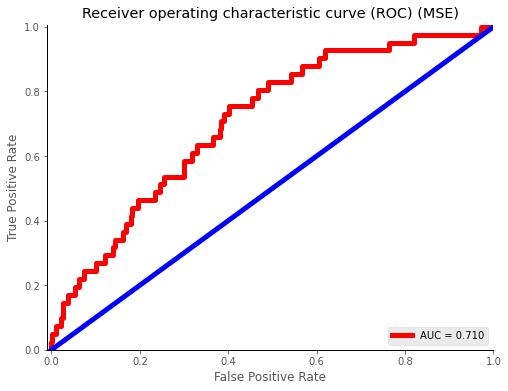

In [32]:
false_pos_rate1, true_pos_rate1, thresholds1 = roc_curve(error_df1.True_class, error_df1.Reconstruction_error)
roc_auc1 = auc(false_pos_rate1, true_pos_rate1,)

plt.plot(false_pos_rate1, true_pos_rate1,'r', linewidth=5, label='AUC = %0.3f'% roc_auc1)
plt.plot([0,1],[0,1],'b', linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC) (MSE)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
ax = plt.axes()
# Setting the background color
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor("white")
plt.show()